# ARIMA

In [10]:
# !pip install yfinance
# !pip install pmdarima

In [3]:
# Google Colab
from google.colab import drive
import os

# General
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# sklearn
from sklearn.metrics import  mean_absolute_error, mean_squared_error, r2_score

# pmdarima
import pmdarima as pm
from pmdarima.arima import decompose
from pmdarima.utils import decomposed_plot
from pmdarima.arima.stationarity import ADFTest
from pmdarima.arima.utils import ndiffs
from pmdarima import model_selection

# statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA

In [4]:
# Mount Google Drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [5]:
# Get the current working directory
print(os.getcwd())

/content


In [6]:
# Drive path is the path where I upload the ETFs history file
drive_path_csv = '/gdrive/MyDrive/Capstone_Project/REIT_ETFs.csv'
drive_path_util = '/gdrive/MyDrive/Capstone_Project/util.py'

# Expect to move the file into the local path
local_path = '/content'

In [7]:
# Copy the file in drive path
!cp '{drive_path_csv}' .
!cp '{drive_path_util}' .

# Change the file from drive path to the local path
os.chdir(local_path)

In [11]:
import util as ut

In [12]:
data = pd.read_csv('/content/REIT_ETFs.csv')
data

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker
0,2004-09-29,23.794544,23.861371,23.789772,23.794544,205800,0.0,0.0,VNQ
1,2004-09-30,23.866143,24.023660,23.861370,23.985474,27900,0.0,0.0,VNQ
2,2004-10-01,24.033207,24.462799,23.985476,24.429386,129800,0.0,0.0,VNQ
3,2004-10-04,24.529629,24.606000,24.529629,24.534403,8100,0.0,0.0,VNQ
4,2004-10-05,24.534403,24.582135,24.510535,24.529629,11900,0.0,0.0,VNQ
...,...,...,...,...,...,...,...,...,...
53434,2021-06-17,9.280000,9.290000,9.220000,9.220000,5200,0.0,0.0,REK
53435,2021-06-18,9.330000,9.370000,9.270000,9.370000,22800,0.0,0.0,REK
53436,2021-06-21,9.320000,9.320000,9.170000,9.170000,22900,0.0,0.0,REK
53437,2021-06-22,9.160000,9.230000,9.160000,9.220000,6200,0.0,0.0,REK


In [13]:
vnq = data.loc[data['Ticker'] == "VNQ"]

In [14]:
# Convert Date column to datetime64 type
vnq['Date'] = pd.to_datetime(vnq['Date'])

# Set index to a datetime index
vnq.set_index('Date', inplace=True)

# Check
display(vnq.head())

print(vnq.index.inferred_type == "datetime64")

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker
Date,,,,,,,,
2004-09-29,23.794544,23.861371,23.789772,23.794544,205800,0.0,0.0,VNQ
2004-09-30,23.866143,24.023660,23.861370,23.985474,27900,0.0,0.0,VNQ
2004-10-01,24.033207,24.462799,23.985476,24.429386,129800,0.0,0.0,VNQ
2004-10-04,24.529629,24.606000,24.529629,24.534403,8100,0.0,0.0,VNQ
2004-10-05,24.534403,24.582135,24.510535,24.529629,11900,0.0,0.0,VNQ


True


## VNQ

## Preprocessing

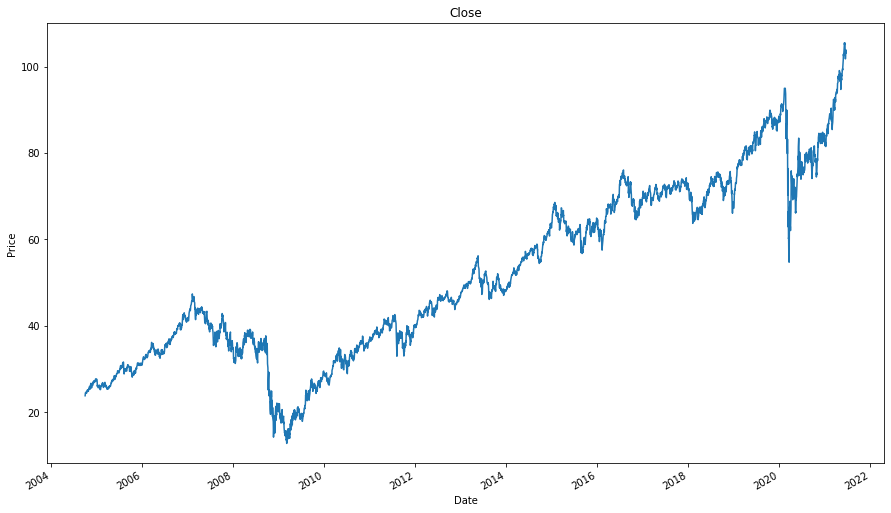

In [15]:
# Original time series
ut.visualize_time_series(vnq['Close'])

## Stationary Check + Decomposition Plot

[additive or multiplicative?](https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.decompose.html)

- number of trading days in a year: 253
- number of trading days in a month: 22

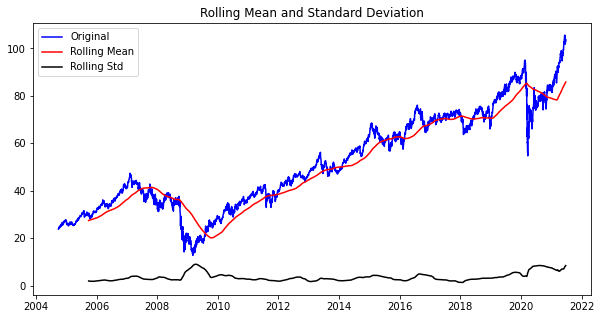

Non-stationary, because p ≥ 0.05 

Results of Dickey-Fuller test: 

Test Statistic                    0.206874
p-value                           0.972645
#Lags Used                       29.000000
Number of Observations Used    4183.000000
Critical Value (1%)              -3.431914
Critical Value (5%)              -2.862231
Critical Value (10%)             -2.567138
dtype: float64


In [16]:
ut.stationary_check_statsmodels(vnq['Close'], 253)

In [17]:
ut.stationary_check_pmdarima(vnq['Close'])

P-Value: 0.3360275927619048, so should you difference the data? True


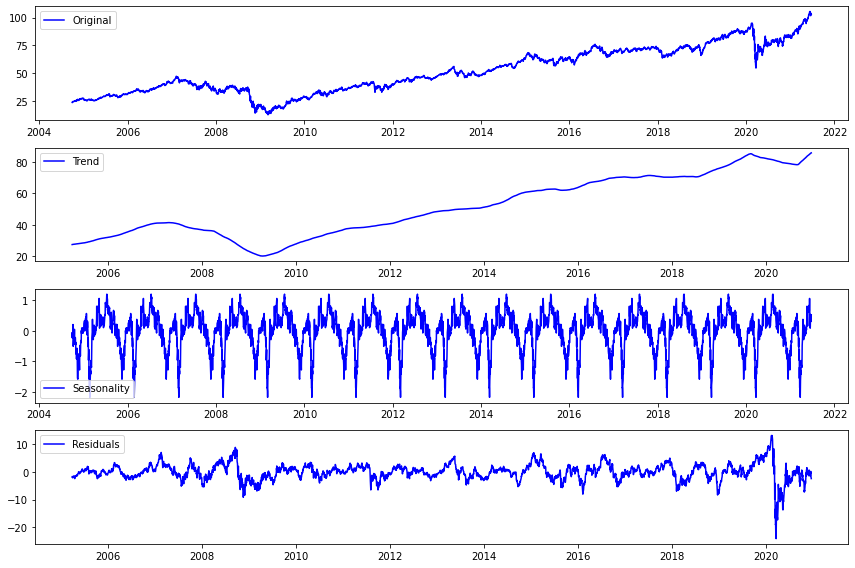

In [18]:
ut.decomposition_plot_statsmodels(vnq['Close'], 253)

- Seasonality is very small

## Detrend (differencing)
- estimate ARIMA [differencing term](https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.ndiffs.html)

In [19]:
adf_diffs = ndiffs(vnq['Close'], alpha=0.05,  test='adf', max_d=10)

print(f"Estimated differencing term: {adf_diffs}")

Estimated differencing term: 1


In [20]:
diff_ts = ut.detrend_differencing(vnq['Close'], periods=1)

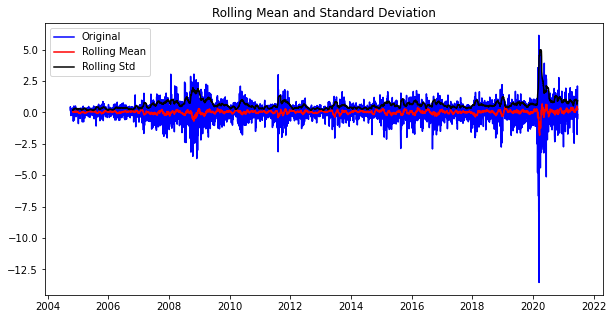

Stationary, because p < 0.05 

Results of Dickey-Fuller test: 

Test Statistic                -1.349919e+01
p-value                        3.000131e-25
#Lags Used                     2.800000e+01
Number of Observations Used    4.183000e+03
Critical Value (1%)           -3.431914e+00
Critical Value (5%)           -2.862231e+00
Critical Value (10%)          -2.567138e+00
dtype: float64


In [21]:
ut.stationary_check_statsmodels(diff_ts, 22)

## ACF & PACF

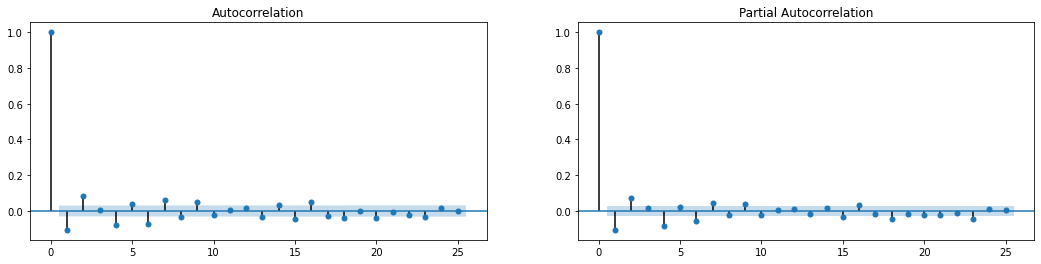

In [22]:
ut.plot_ACF_PACF(diff_ts)

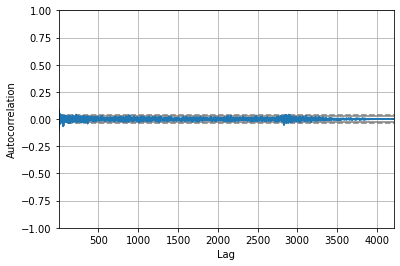

In [23]:
ut.pd_ACF(diff_ts)

## ARIMA Model

In [24]:
# Train Test Split
# Use pmdarima library
train, test = model_selection.train_test_split(vnq['Close'], test_size=253)

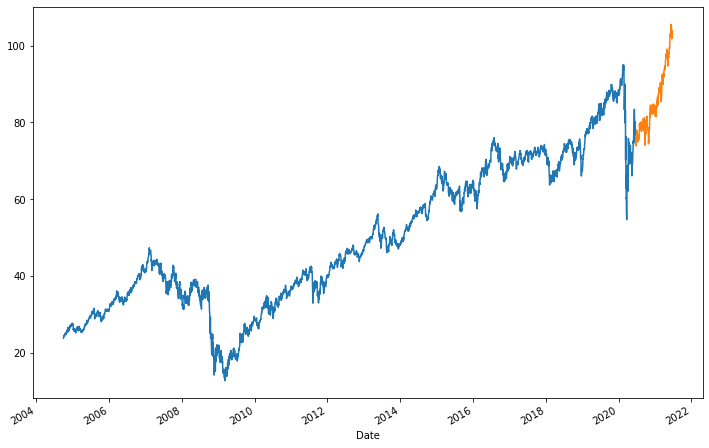

In [25]:
train.plot(figsize=(12,8))
test.plot(figsize=(12,8));

[pmdarima.auto_arima](https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html)
- m = 4 quarterly
- m = 12 monthly
- m = 1 annually

In [26]:
# Use pmdarima to find the optimal p, d, q
arima_pmd = pm.auto_arima(train,
                          d=1,
                          max_p=2,
                          max_q=2,
                          error_action='ignore', 
                          trace=True,
                          suppress_warnings=True, 
                          maxiter=100,
                          seasonal=True,
                          m=1)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=9012.397, Time=3.31 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9100.322, Time=0.32 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=9048.308, Time=0.23 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=9056.214, Time=0.56 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9099.545, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=9020.609, Time=1.60 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=9026.923, Time=1.74 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=9038.573, Time=1.15 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=9011.747, Time=2.21 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=9019.866, Time=1.14 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=9026.211, Time=1.38 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=9038.059, Time=0.47 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 14.226 seconds


- [statsmodels arima](https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/)
- [forecast](https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARMAResults.forecast.html)
- [example](https://dataplatform.cloud.ibm.com/exchange/public/entry/view/1835c567cd309d54fc797900f79a60f9)
- [SARIMAX](https://www.geeksforgeeks.org/python-arima-model-for-time-series-forecasting/)

In [27]:
print(arima_pmd.order)

(2, 1, 2)


In [28]:
# Change the train values into a list
history = [x for x in train] 

pred = [] # prediction
cf_left = [] # confidence interval: lower bound
cf_right = [] # confidence interval: upper bound


for t in range(len(test)):
    # Fit the model using statsmodels library
    arima = ARIMA(history, order=(2,1,2)).fit()
    
    # Make prediction
    forecast, stderr, conf_int = arima.forecast()
    
    # Predicted price
    prediction = forecast
    pred.append(prediction)
    
    # Confidence interval for predicted price
    cf_left.append(conf_int[0][0])
    cf_right.append(conf_int[0][1])
    
    # Actual price
    actual = test[t]
    history.append(actual)
    print('predicted=%f, expected=%f' % (prediction, actual))

predicted=77.312293, expected=76.604248
predicted=76.340527, expected=74.421883
predicted=74.676599, expected=75.372398
predicted=75.065348, expected=73.925735
predicted=74.172357, expected=75.352982
predicted=75.249969, expected=76.246223
predicted=76.015120, expected=78.003593
predicted=77.961947, expected=77.780281
predicted=77.949912, expected=77.741447
predicted=77.714150, expected=76.197685
predicted=76.336902, expected=76.090889
predicted=76.010227, expected=75.615128
predicted=75.661845, expected=75.848160
predicted=75.837644, expected=74.945206
predicted=75.066640, expected=75.576294
predicted=75.442717, expected=76.314186
predicted=76.288494, expected=75.401535
predicted=75.628061, expected=76.382156
predicted=76.177308, expected=75.469498
predicted=75.630630, expected=75.653969
predicted=75.634542, expected=76.809364
predicted=76.653426, expected=76.488953
predicted=76.672854, expected=75.925827
predicted=75.991387, expected=76.644310
predicted=76.460509, expected=78.168648


In [29]:
ut.evaluate(test, pred)

MAE: 0.7632
RMSE: 0.9599
R^2: 0.9870


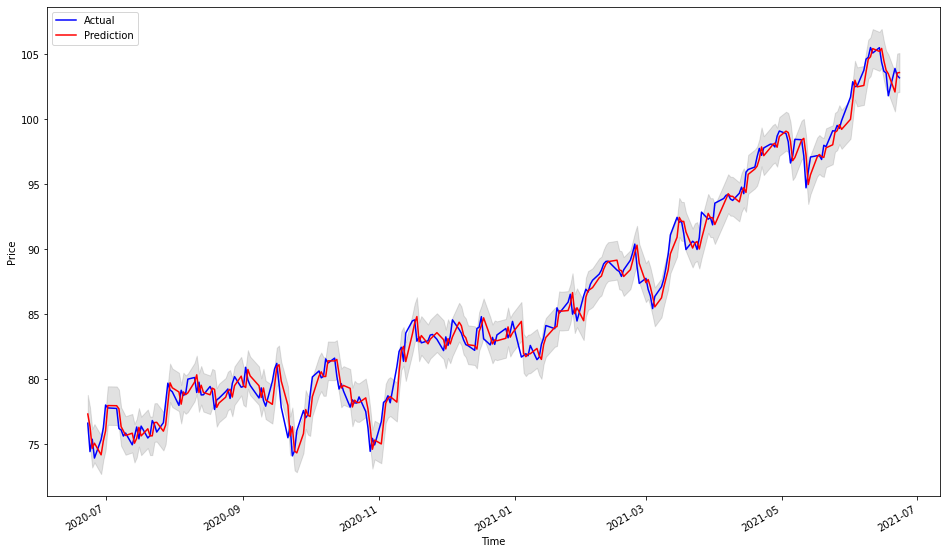

In [30]:
# Plot the prediction
ax = vnq.Close[test.index[0]:test.index[-1]].plot(figsize=(16,10), color='blue')

# Create a df for the predictions using same index as test part
df = pd.DataFrame(pred).set_index(test.index)
df.plot(ax=ax, color= 'red')

# Add the confidence interval for prediction
ax.fill_between(test.index, cf_left, cf_right, color='dimgray', alpha=0.2)

# Add the labels to the plot.
plt.legend(('Actual', 'Prediction'), loc=2)
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()

https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

https://machinelearningmastery.com/save-arima-time-series-forecasting-model-python/

In [ ]:
# arima.save('/content/arima_statsmodels.pkl')